CS 4277: Deep Learning Group Project

## CS 4277: *Deep Learning* Group Project
### Members:
- Nicholas Hodge
- Joshua Peeples
- Jonathan Turner

### This project is our attempt at the Stanford RNA 3D Folding Challenge, found at:

https://www.kaggle.com/competitions/stanford-rna-3d-folding

**For this project to run:**

1. Install matplotlib in your Jupyter Kernel: Block [1]
2. Setup correct path files to your train dataset: Block [7] (there is a comment)

**Future work:**

1. Setup validation correctly
2. Test
3. Return Submission.csv as per requirements

In [1]:
# Uncomment and run if matplotlib not installed
# !  python -m pip install matplotlib

# Replace the following with the location of the dataset root
# Ex: DATASET_ROOT = '/path/to/dataset/files'

DATASET_ROOT = '/kaggle/input/stanford-rna-3d-folding/' # Default location for Project

In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.auto import tqdm

# containers to accumulate metrics
batch_loss_history = [] # one entry per batch
epoch_loss_history = [] # one entry per epoch

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print (device)

cuda


# Training

In [4]:
NUC_TO_IDX = {
    "A": 0,
    "U": 1,
    "C": 2,
    "G": 3,
    "N": 4 # There are characters *other* than the above 4 sometimes. 'N' is standard for "unknown" (apparently)
}
PAD_IDX = 5
VOCAB_SIZE = len(NUC_TO_IDX) + 1

# Annotated to avoid later confusion - Nick
# This is inherits the Dataset class from pytorch to allow for the dataset to be an Iterable (i.e. work a LOT faster)
class RNADataset(Dataset):
    def __init__(self, seq_csv_path, coords_csv_path):
        # Read both train CSVs (the 'labels' csv -> 'coords')
        self.sequences_df = pd.read_csv(seq_csv_path)
        coords_df_raw = pd.read_csv(coords_csv_path)

        # We are going to get the base_id from each row in coords to associate them with the correct sequence.
        # 1SCL_A_5 becomes 1SCL_A
        coords_df_raw["base_id"] = coords_df_raw["ID"].apply(lambda x: "_".join(x.split("_")[:2]))

        # Now we are going to create groups of coords, where each group corresponds with the same sequence
        # Unfortunately some sequences have missing coord values, but I am going to assume that there are potential
        # sequences that have some missing and some not. So:

        # Method to remove entire groups where *any* row has missing coords
        def is_group_valid(group):
            return group[["x_1", "y_1", "z_1"]].notna().all().all() # returns only rows where all columns are good

        valid_groups = [
            group for _, group in coords_df_raw.groupby("base_id") if is_group_valid(group)
        ]

        # Concatenate all valid groups into a new coords_df
        self.coords_df = pd.concat(valid_groups, ignore_index=True)

        # Build groups and valid sequence IDs list
        self.coord_groups = self.coords_df.groupby("base_id")
        self.valid_ids = set(self.coord_groups.groups.keys())

        # Filter sequences to only include those with clean coordinate groups (prevents later tensors from being mishaped)
        self.sequences_df = self.sequences_df[self.sequences_df["target_id"].isin(self.valid_ids)]

    # Optional but Pytorch docs suggest this for 'Sampler' implmentations (might need that?)
    def __len__(self):
        return len(self.sequences_df)

    # Optional but Pytorch docs suggest this for speedup batched samples loading
    def __getitem__(self, idx):
        row = self.sequences_df.iloc[idx]
        seq_id = row["target_id"]
        sequence = row["sequence"]

        token_ids = [NUC_TO_IDX.get(nuc, NUC_TO_IDX["N"]) for nuc in sequence]
        token_ids = torch.tensor(token_ids, dtype=torch.long)

        # Here we introduce standardization to the coordinates

        # TODO: calculate the following values somewhere in the document in case the dataset changes:
        # Currently precalculated values
        mean_x = 80.44731529117061
        std_x = 147.42231938515297
        mean_y = 84.04072703411182
        std_y = 114.92890150429712
        mean_z = 98.61122565112208
        std_z = 119.41066506340083

        coords_standardized = self.coord_groups.get_group(seq_id)[["x_1", "y_1", "z_1"]].values
        coords_standardized[:, 0] = (coords_standardized[:, 0] - mean_x) / std_x
        coords_standardized[:, 1] = (coords_standardized[:, 1] - mean_y) / std_y
        coords_standardized[:, 2] = (coords_standardized[:, 2] - mean_z) / std_z

        coords = torch.tensor(coords_standardized, dtype=torch.float32)

        return token_ids, coords

In [5]:
# Pad sequences in train_collate_fn
def collate_fn(batch):
    sequences, coords = zip(*batch)

    # Pad sequences with PAD_IDX
    seq_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=PAD_IDX)
    coord_padded = torch.nn.utils.rnn.pad_sequence(coords, batch_first=True, padding_value=0.0)

    # Mask should check against PAD_IDX
    mask = (seq_padded != PAD_IDX).unsqueeze(1).unsqueeze(2)

    return seq_padded, coord_padded, mask

In [6]:
class RNAValidationDataset(Dataset):
    def __init__(self, val_seq_csv_path, val_labels_csv_path):
        self.sequences_df = pd.read_csv(val_seq_csv_path)
        labels = pd.read_csv(val_labels_csv_path)

        # Create base_id to group coordinates
        labels["base_id"] = labels["ID"].apply(lambda x: x.split("_")[0])

        # Group by base_id (each RNA sequence)
        self.coord_groups = labels.groupby("base_id")
        self.valid_ids = set(self.coord_groups.groups.keys())


    def __len__(self):
        return len(self.sequences_df)

    def __getitem__(self, idx):
        row = self.sequences_df.iloc[idx]
        seq_id = row["target_id"]
        sequence = row["sequence"]

        token_ids = [NUC_TO_IDX.get(nuc, NUC_TO_IDX["N"]) for nuc in sequence]
        token_ids = torch.tensor(token_ids, dtype=torch.long)

        # Extract all xyz coordinate columns
        coord_cols = []
        for i in range(1, 41):
            coord_cols += [f"x_{i}", f"y_{i}", f"z_{i}"]

        coords_df = self.coord_groups.get_group(seq_id)[coord_cols]

        # Reshape to (num_nucleotides, 40, 3)
        coords_np = coords_df.values.reshape(len(coords_df), 40, 3)

        # Mask 1e18 values
        valid_mask = ~(coords_np == -1e18).all(axis=2)  # shape: (num_nucleotides, 40)

        # Keep only valid coordinate sets
        valid_coords = [coords_np[i][valid_mask[i]] for i in range(len(coords_np))]

        # Pad to max number of valid sets per nucleotide in this sample
        max_sets = max(len(c) for c in valid_coords) # 40, set to be variable for updates -nick
        padded_coords = np.full((len(valid_coords), max_sets, 3), -1e18, dtype=np.float32)

        for i, c in enumerate(valid_coords):
            padded_coords[i, :len(c)] = c

        coords = torch.tensor(padded_coords, dtype=torch.float32)

        return token_ids, coords

In [7]:
def validate(model, val_loader, epoch):
    model.eval()
    results = []

    with torch.no_grad():
        for i, (seqs, coords, mask) in enumerate(tqdm(val_loader, desc="Validation")):
            seqs = seqs.to(device)


In [8]:
# Source: Aladdin Persson on YouTube (then modified to have an encoder-only architecture)

class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads, dropout):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (self.head_dim * heads == embed_size), "Embed size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, values, keys, query, mask):
        N, value_len, _ = values.shape
        _, key_len, _ = keys.shape
        _, query_len, _ = query.shape

        # Split embedding into self.heads pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # queries shape: (N, query_len, heads, heads_dim)
        # keys shape: (N, key_len, heads, heads_dim)
        # energy shape: (N, heads, query_len, key_len)

        if mask is not None:
            # mask: (batch, 1, 1, seq_len) -> broadcastable to (batch, heads, query_len, key_len)
            energy = energy.masked_fill(mask == 0, float("-1e9"))

        attention = torch.softmax(energy / (self.embed_size ** 0.5), dim=3)
        attention = self.dropout(attention)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        # attention shape: (N, heads, query_len, key_len)
        # values shape: (N, value_len, heads, heads_dim)
        # after einsum (N, query_len, heads, head_dim) then flatten last two dimensions

        out = self.fc_out(out)
        return out

class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads, dropout)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(forward_expansion * embed_size, embed_size)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attention = self.attention(x, x, x, mask)

        x = self.dropout(self.norm1(attention + x))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

class RNA3DFoldPredictor(nn.Module):
    def __init__(self,
                 vocab_size,
                 embed_size,
                 num_layers,
                 heads,
                 forward_expansion,
                 dropout,
                 max_length):
        super().__init__()
        self.embed_size = embed_size
        self.token_embedding = nn.Embedding(vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList([
            TransformerBlock(embed_size, heads, dropout, forward_expansion)
            for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(embed_size, 3)  # Predict (x, y, z)

    def forward(self, x, mask=None):
        N, seq_len = x.shape

        positions = torch.arange(0, seq_len).unsqueeze(0).expand(N, seq_len).to(x.device)

        out = self.token_embedding(x) + self.position_embedding(positions)
        for layer in self.layers:
            out = layer(out, mask)

        coords = self.fc_out(out)
        return coords

    def predict_multiple(self, x, n_samples=5):
        self.train()  # Activate dropout during inference
        with torch.no_grad():
            outputs = [self(x) for _ in range(n_samples)]
        return torch.stack(outputs)  # Shape: (n_samples, batch_size, seq_len, 3)

In [9]:
# live‑plotter
plot_display_handle = None   # will hold the DisplayHandle returned by display()

def plot_training_progress(epoch):
    # Draw the loss curves without clearing cell output
    global plot_display_handle

    # build figure
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    axs[0].plot(batch_loss_history, linewidth=1)
    axs[0].set_title("Batch loss")
    axs[0].set_xlabel("Batch #")
    axs[0].set_ylabel("Mean Squared Error")

    axs[1].plot(epoch_loss_history, marker="o")
    axs[1].set_title("Epoch loss")
    axs[1].set_xlabel("Epoch")

    plt.tight_layout()
    plt.suptitle(f"Training progress after epoch {epoch+1}", y=1.05, fontsize=14)

    # first call then create display, later calls then update it
    if plot_display_handle is None:
        plot_display_handle = display(fig, display_id=True)
    else:
        plot_display_handle.update(fig)

    plt.close(fig)  # prevent duplicate static image output

Epoch 1/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 1/60 | mean_loss: 1.0323 | last_batch_loss: 0.4205


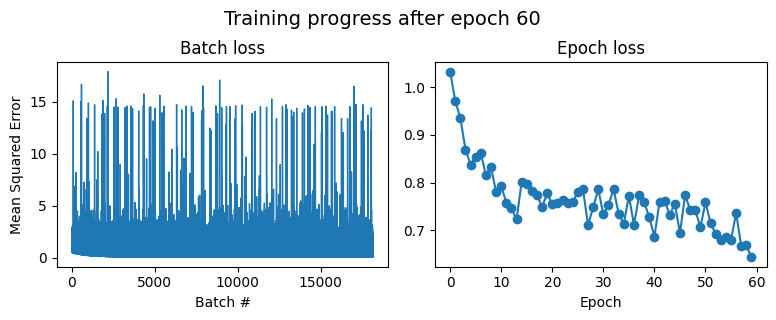

Epoch 2/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 2/60 | mean_loss: 0.9708 | last_batch_loss: 0.4064


Epoch 3/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 3/60 | mean_loss: 0.9352 | last_batch_loss: 3.1610


Epoch 4/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 4/60 | mean_loss: 0.8692 | last_batch_loss: 2.0680


Epoch 5/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 5/60 | mean_loss: 0.8376 | last_batch_loss: 0.2430


Epoch 6/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 6/60 | mean_loss: 0.8532 | last_batch_loss: 0.2333


Epoch 7/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 7/60 | mean_loss: 0.8622 | last_batch_loss: 0.6154


Epoch 8/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 8/60 | mean_loss: 0.8150 | last_batch_loss: 0.7532


Epoch 9/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 9/60 | mean_loss: 0.8329 | last_batch_loss: 0.1666


Epoch 10/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 10/60 | mean_loss: 0.7801 | last_batch_loss: 0.0958


Epoch 11/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 11/60 | mean_loss: 0.7927 | last_batch_loss: 1.0311


Epoch 12/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 12/60 | mean_loss: 0.7578 | last_batch_loss: 1.3125


Epoch 13/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 13/60 | mean_loss: 0.7463 | last_batch_loss: 0.6779


Epoch 14/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 14/60 | mean_loss: 0.7229 | last_batch_loss: 0.1393


Epoch 15/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 15/60 | mean_loss: 0.8011 | last_batch_loss: 0.9941


Epoch 16/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 16/60 | mean_loss: 0.7970 | last_batch_loss: 0.1276


Epoch 17/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 17/60 | mean_loss: 0.7830 | last_batch_loss: 0.7512


Epoch 18/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 18/60 | mean_loss: 0.7738 | last_batch_loss: 0.3011


Epoch 19/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 19/60 | mean_loss: 0.7492 | last_batch_loss: 1.6443


Epoch 20/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 20/60 | mean_loss: 0.7773 | last_batch_loss: 0.1128


Epoch 21/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 21/60 | mean_loss: 0.7546 | last_batch_loss: 0.4154


Epoch 22/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 22/60 | mean_loss: 0.7568 | last_batch_loss: 1.5475


Epoch 23/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 23/60 | mean_loss: 0.7628 | last_batch_loss: 0.6859


Epoch 24/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 24/60 | mean_loss: 0.7574 | last_batch_loss: 0.0661


Epoch 25/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 25/60 | mean_loss: 0.7584 | last_batch_loss: 0.4138


Epoch 26/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 26/60 | mean_loss: 0.7807 | last_batch_loss: 0.4309


Epoch 27/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 27/60 | mean_loss: 0.7869 | last_batch_loss: 1.5222


Epoch 28/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 28/60 | mean_loss: 0.7111 | last_batch_loss: 0.0675


Epoch 29/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 29/60 | mean_loss: 0.7481 | last_batch_loss: 0.1373


Epoch 30/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 30/60 | mean_loss: 0.7860 | last_batch_loss: 0.0556


Epoch 31/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 31/60 | mean_loss: 0.7336 | last_batch_loss: 0.2225


Epoch 32/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 32/60 | mean_loss: 0.7534 | last_batch_loss: 0.0888


Epoch 33/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 33/60 | mean_loss: 0.7864 | last_batch_loss: 0.0741


Epoch 34/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 34/60 | mean_loss: 0.7347 | last_batch_loss: 0.0737


Epoch 35/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 35/60 | mean_loss: 0.7138 | last_batch_loss: 0.0481


Epoch 36/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 36/60 | mean_loss: 0.7720 | last_batch_loss: 1.5029


Epoch 37/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 37/60 | mean_loss: 0.7117 | last_batch_loss: 0.4891


Epoch 38/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 38/60 | mean_loss: 0.7736 | last_batch_loss: 0.0619


Epoch 39/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 39/60 | mean_loss: 0.7587 | last_batch_loss: 0.0545


Epoch 40/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 40/60 | mean_loss: 0.7271 | last_batch_loss: 0.0501


Epoch 41/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 41/60 | mean_loss: 0.6872 | last_batch_loss: 0.2972


Epoch 42/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 42/60 | mean_loss: 0.7590 | last_batch_loss: 0.3764


Epoch 43/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 43/60 | mean_loss: 0.7615 | last_batch_loss: 0.4989


Epoch 44/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 44/60 | mean_loss: 0.7323 | last_batch_loss: 0.0613


Epoch 45/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 45/60 | mean_loss: 0.7559 | last_batch_loss: 0.3676


Epoch 46/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 46/60 | mean_loss: 0.6945 | last_batch_loss: 2.4077


Epoch 47/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 47/60 | mean_loss: 0.7733 | last_batch_loss: 0.1497


Epoch 48/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 48/60 | mean_loss: 0.7437 | last_batch_loss: 0.0640


Epoch 49/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 49/60 | mean_loss: 0.7428 | last_batch_loss: 0.1452


Epoch 50/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 50/60 | mean_loss: 0.7063 | last_batch_loss: 0.0321


Epoch 51/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 51/60 | mean_loss: 0.7588 | last_batch_loss: 0.0580


Epoch 52/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 52/60 | mean_loss: 0.7151 | last_batch_loss: 0.1152


Epoch 53/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 53/60 | mean_loss: 0.6921 | last_batch_loss: 0.7745


Epoch 54/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 54/60 | mean_loss: 0.6800 | last_batch_loss: 2.1336


Epoch 55/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 55/60 | mean_loss: 0.6865 | last_batch_loss: 0.1974


Epoch 56/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 56/60 | mean_loss: 0.6803 | last_batch_loss: 0.0413


Epoch 57/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 57/60 | mean_loss: 0.7363 | last_batch_loss: 0.0270


Epoch 58/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 58/60 | mean_loss: 0.6664 | last_batch_loss: 0.0199


Epoch 59/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 59/60 | mean_loss: 0.6689 | last_batch_loss: 0.1126


Epoch 60/60:   0%|          | 0/303 [00:00<?, ?batch/s]

Epoch 60/60 | mean_loss: 0.6434 | last_batch_loss: 1.6635


In [10]:
dataset = RNADataset(f"{DATASET_ROOT}/train_sequences.csv", f"{DATASET_ROOT}/train_labels.csv") # replace with your *actual* path
loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
# Ran at batch_size=2 due to memory constraints FYI

model = RNA3DFoldPredictor(
    vocab_size=VOCAB_SIZE,
    embed_size=64,
    num_layers=4,
    heads=4,
    forward_expansion=4,
    dropout=0.2,
    max_length=4298, # nearest multiple of 2 is 8192...actual max is 4298
).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# TODO: Remove these comments before submission
# were only used for debugging (test is misleading name lol)

# test_batch = next(iter(loader))
# seqs, coords, mask = [x.to(device) for x in test_batch]
# print("Max token ID:", torch.max(seqs))  # Should be <= 3
# print("Embedding size:", model.token_embedding.num_embeddings)  # Should be 4

# with torch.no_grad():
#     outputs = model(seqs, mask)
# print("Output shape:", outputs.shape)

num_epochs = 60
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    batch_num = 0
    valid_batches = 0 # number of batches that actually updated the model
    last_batch_loss = None # loss of the most recent successful batch
    window_losses = [] # collects losses to compute 50 batch running mean

    # tqdm bar stays in the terminal after finishing (leave=True)
    batch_iterator = tqdm(
        loader,
        desc=f"Epoch {epoch+1}/{num_epochs}",
        unit="batch",
        leave=True,
        position=0,
    )

    for batch_num, (seqs, coords, mask) in enumerate(batch_iterator, start=1):
        # print("Max token ID in batch:", torch.max(seqs))
        seqs, coords, mask = seqs.to(device), coords.to(device), mask.to(device)

        # check for any NaN values
        if torch.isnan(coords).any() or torch.isinf(coords).any():
            batch_iterator.write(f"WARNING: NaN/Inf found in target coordinates in batch {batch_num}! Skipping batch.")
            continue

        optimizer.zero_grad()
        outputs = model(seqs, mask)

        # mask padding tokens only
        non_pad_mask = (seqs != PAD_IDX) # Shape: (batch_size, seq_len)
        outputs_masked = outputs[non_pad_mask]
        coords_masked = coords[non_pad_mask]

        # Calculate loss ONLY on non-padded elements
        if outputs_masked.nelement() == 0:
            batch_iterator.write(f"WARNING: Only padding elements in batch {batch_num}! Skipping batch.")
            continue

        loss = criterion(outputs_masked, coords_masked)

        # Skip if loss is NaN or Inf
        if torch.isnan(loss) or torch.isinf(loss):
            batch_iterator.write(f"WARNING: NaN detected in loss for batch {batch_num}! Skipping batch.")
            # Add more debugging here if needed: print outputs_masked, coords_masked
            continue # Skip optimization step for this batch

        # Backpropagation
        loss.backward()
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        last_batch_loss = loss.item()
        batch_loss_history.append(last_batch_loss)
        window_losses.append(last_batch_loss)

        total_loss += last_batch_loss
        valid_batches += 1

        # update tqdm bar postfix
        batch_iterator.set_postfix({"batch_loss": f"{last_batch_loss:.4f}"})

        # Every 50 valid batches, print the running mean and reset the window (disabled because it's spammy)
        if len(window_losses) == 50:
            mean50 = sum(window_losses) / 50
            # print(f"Mean loss over batches {batch_num-49}-{batch_num}: {mean50:.4f}")
            window_losses.clear()

    # Epoch‑level summary
    if valid_batches > 0:
        epoch_loss = total_loss / valid_batches
        epoch_loss_history.append(epoch_loss)
        print(
            f"Epoch {epoch+1}/{num_epochs}"
            f" | mean_loss: {epoch_loss:.4f}"
            f" | last_batch_loss: {last_batch_loss:.4f}"
        )
    else:
        print(f"Epoch {epoch+1} had no valid batches or zero total loss.")

    # live plot (comment out for end‑of‑training plot only)
    plot_training_progress(epoch)

In [19]:
model_path = './model.pth'
torch.save(model.state_dict(), model_path)

# Testing

In [20]:
IDX_TO_NUC = {v: k for k, v in NUC_TO_IDX.items()}
# Testing dataset
class RNATestDataset(Dataset):
    def __init__(self, test_seq_path):
        # Read test csv
        self.data = pd.read_csv(test_seq_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        seq_id = row["target_id"]
        sequence = row["sequence"]

        token_ids = [NUC_TO_IDX.get(nuc, NUC_TO_IDX["N"]) for nuc in sequence]
        token_ids = torch.tensor(token_ids, dtype=torch.long)

        return seq_id, token_ids

In [ ]:
# TODO: Change back to test_sequences.csv below (using val for proof of concept)
test_dataset = RNATestDataset(test_seq_path=DATASET_ROOT+'/validation_sequences.csv')
print(len(test_dataset))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.load_state_dict(torch.load('model.pth')) # load trained model

model.to(device)
model.eval()

# enable dropout
for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

submission_rows = []

with torch.no_grad():
    for seq_id, token_ids in test_loader:
        seq_id = seq_id[0]  # unpack from list
        token_ids = token_ids.to(device).squeeze(0)  # [seq_len]
        sequence = [IDX_TO_NUC[i.item()] for i in token_ids]

        predictions = []

        # Generate 5 predictions
        for _ in range(5):
            output = model(token_ids.unsqueeze(0))  # [1, seq_len, 3]
            coords = output.squeeze(0).cpu().numpy()  # [seq_len, 3]
            predictions.append(coords)

        predictions = np.stack(predictions, axis=0)  # [5, seq_len, 3]

        seq_len = len(sequence)

        # Loop over each nucleotide in the sequence
        for i in range(seq_len):
            row = {
                "ID": f"{seq_id}_{i+1}",
                "resname": sequence[i],
                "resid": i+1
            }
            for j in range(5):  # 5 predictions
                row[f"x_{j+1}"] = predictions[j, i, 0]
                row[f"y_{j+1}"] = predictions[j, i, 1]
                row[f"z_{j+1}"] = predictions[j, i, 2]

            submission_rows.append(row)

In [14]:
# Convert to DataFrame and save
submission_df = pd.DataFrame(submission_rows)
submission_df.to_csv("submission.csv", index=False)

# Ensure the submission file has the correct format
column_order = ['ID', 'resname', 'resid']
for i in range(1, 6):
    for coord in ['x', 'y', 'z']:
        column_order.append(f'{coord}_{i}')
submission_df = submission_df[column_order]

# Save the submission file
submission_df.to_csv('submission.csv', index=False)
print(f"Generated predictions for {len(test_dataset)} RNA sequences")
submission_df.head()

Generated predictions for 12 RNA sequences


,ID,resname,resid,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5
0,R1107_1,G,1,-0.249994,-0.338170,-0.607540,-0.228370,-0.411406,-0.696468,-0.383651,-0.537865,-0.657900,-0.456116,-0.393421,-0.354097,-0.324039,-0.373255,-0.675622
1,R1107_2,G,2,-0.424398,-0.488875,-0.492922,-0.372631,-0.696202,-0.814671,-0.436233,-0.423701,-0.697138,-0.347204,-0.400686,-0.612485,-0.222435,-0.250026,-0.227339
2,R1107_3,G,3,-0.634341,-0.605171,-0.635306,-0.448771,-0.572147,-0.792619,-0.202251,-0.562661,-0.737217,-0.384956,-0.666196,-0.609320,-0.331644,-0.465988,-0.628421
3,R1107_4,G,4,-0.309009,-0.478963,-0.245078,-0.452671,-0.681628,-0.864645,-0.253925,-0.339729,-0.727385,-0.472301,-0.739388,-0.693256,-0.415155,-0.560139,-0.808574
4,R1107_5,G,5,-0.067343,-0.625580,-0.227898,-0.290108,-0.240975,-0.710257,-0.419981,-0.395801,-0.595986,-0.116851,-0.202749,-0.127382,-0.322820,-0.518738,-0.432680


In [15]:
display(pd.read_csv('submission.csv'))

,ID,resname,resid,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5
0,R1107_1,G,1,-0.249994,-0.338170,-0.607541,-0.228370,-0.411406,-0.696468,-0.383651,-0.537865,-0.657900,-0.456116,-0.393421,-0.354097,-0.324039,-0.373255,-0.675622
1,R1107_2,G,2,-0.424398,-0.488875,-0.492922,-0.372631,-0.696202,-0.814671,-0.436233,-0.423701,-0.697138,-0.347204,-0.400686,-0.612485,-0.222435,-0.250026,-0.227339
2,R1107_3,G,3,-0.634341,-0.605171,-0.635306,-0.448771,-0.572147,-0.792619,-0.202251,-0.562661,-0.737217,-0.384956,-0.666196,-0.609320,-0.331644,-0.465988,-0.628421
3,R1107_4,G,4,-0.309009,-0.478963,-0.245078,-0.452671,-0.681628,-0.864645,-0.253925,-0.339729,-0.727385,-0.472301,-0.739388,-0.693256,-0.415155,-0.560139,-0.808574
4,R1107_5,G,5,-0.067343,-0.625580,-0.227898,-0.290108,-0.240975,-0.710257,-0.419981,-0.395801,-0.595986,-0.116851,-0.202749,-0.127382,-0.322819,-0.518738,-0.432680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2510,R1190_114,U,114,-0.408848,-0.349106,-0.543627,-0.281056,-0.408622,-0.518210,-0.331638,-0.434219,-0.490105,0.041717,0.123477,-0.425487,-0.022264,-0.025040,-0.045238
2511,R1190_115,U,115,-0.321299,-0.463662,-0.604712,-0.381971,-0.434299,-0.549594,-0.396763,-0.354428,-0.300811,-0.170259,-0.426462,-0.616527,-0.342283,-0.519740,-0.450043
2512,R1190_116,U,116,-0.182744,-0.243474,-0.242154,-0.312903,-0.311597,-0.570318,-0.270009,-0.624647,-0.451606,-0.297533,-0.397919,-0.530425,-0.217354,-0.339017,-0.585956
2513,R1190_117,U,117,-0.521902,-0.428276,-0.370330,-0.311180,-0.191865,-0.658139,-0.345671,-0.548697,-0.622186,-0.224447,-0.370638,-0.314984,-0.180682,-0.244044,-0.129591


In [17]:
from metric import score
validation_labels = pd.read_csv(f"{DATASET_ROOT}/validation_labels.csv")
tm_score = score(validation_labels, submission_df.copy(), row_id_column_name = 'ID')
print(f"Average TM-SCore: {tm_score:.4f}")

Average TM-SCore: 0.0279
